In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import re
import FinanceDataReader as fdr
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/23-2 창의적종합설계 /LSTM/231205/sm_merged_f.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled
0,2023-02-01,87700,88000,86100,86700,410616,-0.014773,0.349326,0.623016
1,2023-02-02,86900,89900,86100,89100,683339,0.027682,0.382584,0.647312
2,2023-02-03,89900,95900,88100,91000,2363145,0.021324,0.491089,0.625513
3,2023-02-06,90500,93900,89600,92200,646786,0.013187,0.383724,0.641886
4,2023-02-07,93000,99700,85700,90100,3863446,-0.022777,0.404888,0.623312


<ipython-input-5-dca7995fdbe1>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


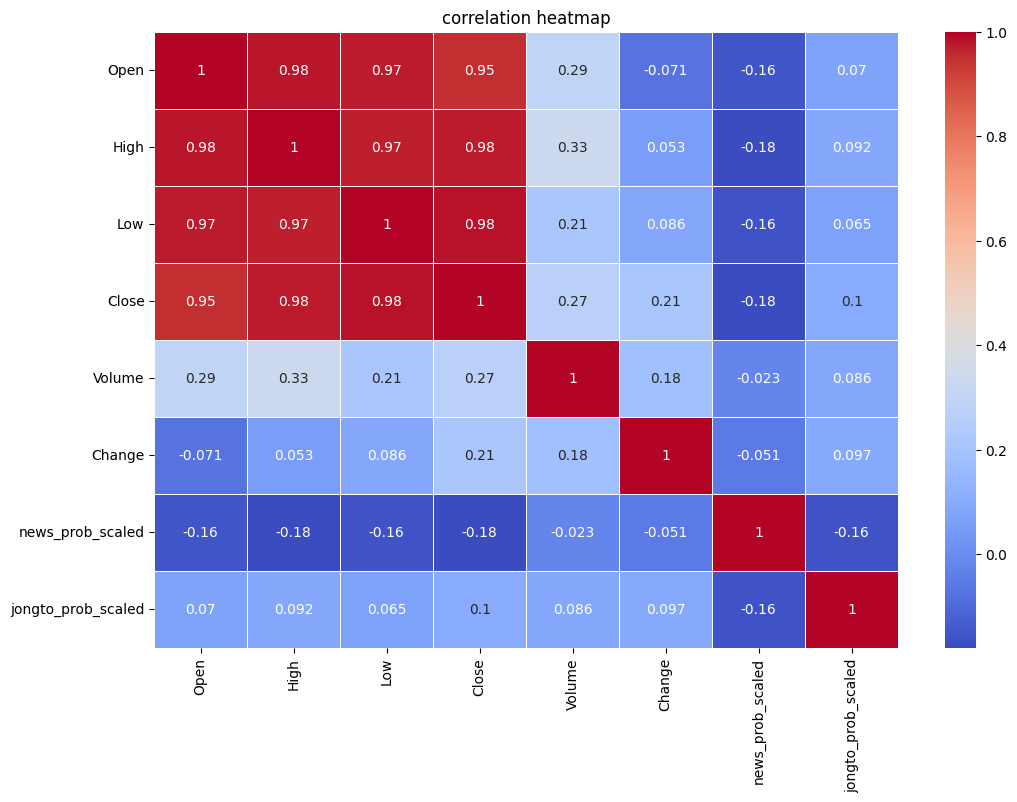

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('correlation heatmap')
plt.show()

### 전처리 및 Window Dataset

In [ ]:
df.drop('Date', axis=1, inplace=True)
df

,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled
0,87700,88000,86100,86700,410616,-0.014773,0.349326,0.623016
1,86900,89900,86100,89100,683339,0.027682,0.382584,0.647312
2,89900,95900,88100,91000,2363145,0.021324,0.491089,0.625513
3,90500,93900,89600,92200,646786,0.013187,0.383724,0.641886
4,93000,99700,85700,90100,3863446,-0.022777,0.404888,0.623312
...,...,...,...,...,...,...,...,...
119,116700,129900,116600,124900,723958,0.071184,0.259010,0.641866
120,125500,125600,116900,116900,452799,-0.064051,0.395371,0.563662
121,117000,124300,117000,123400,370524,0.055603,0.349430,0.801364
122,123600,128500,122100,128000,258017,0.037277,0.425056,0.508992


In [ ]:
df.drop('news_prob_scaled', axis=1, inplace=True)

In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change',
       'jongto_prob_scaled'],
      dtype='object')

In [ ]:
y = df["Close"]
x = df.drop("Close",axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

In [ ]:
train = pd.concat([x_train,y_train], axis=1)
test = pd.concat([x_test,y_test], axis=1)

In [ ]:
train = pd.concat([x_train,y_train], axis=1)
test = pd.concat([x_test,y_test], axis=1)

In [ ]:
sc = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']


train[scale_cols] = sc.fit_transform(train[scale_cols])
test[scale_cols] = sc.transform(test[scale_cols])

In [ ]:
# many2many -> outpu_window size = 1로 함수 수정
def windowDataset(df, window_size, batch_size, shuffle) :
    x = df.drop("Close",axis=1)
    y = df["Close"]
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, stride = 1, shift = 1, drop_remainder = True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices([y[i:i+1].values for i in range(window_size, len(y)-1)])

    data = tf.data.Dataset.zip((ds_x,ds_y))

    #if shuffle :
        #data = data.shuffle(10)

    return data.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE = 3
BATCH_SIZE=1
ratio = int(len(train) * 0.8)

train_data = windowDataset(train[:ratio], WINDOW_SIZE, BATCH_SIZE, shuffle= True)
val_data = windowDataset(train[ratio:], WINDOW_SIZE, BATCH_SIZE, shuffle = False)
test_data = windowDataset(test, WINDOW_SIZE, BATCH_SIZE, shuffle = False)

In [ ]:
for data in train_data.take(1):
    print(f'학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): (1, 3, 6)
학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): (1, 1)


In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [ ]:
len(test)

25

### LSTM

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=7,
           padding="causal",
           activation="relu",
           input_shape=[None, 6]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
loss = Huber()
optimizer = Adam(0.0001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [ ]:
history = model.fit(train_data,
                    validation_data=(val_data),
                    epochs=100,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     71/Unknown - 8s 8ms/step - loss: 0.0563 - mse: 0.1126
Epoch 1: val_loss improved from inf to 0.02716, saving model to tmp/ckeckpointer.ckpt
75/75 [==============================] - 10s 38ms/step - loss: 0.0542 - mse: 0.1083 - val_loss: 0.0272 - val_mse: 0.0543
Epoch 2/100
71/75 [===========================>..] - ETA: 0s - loss: 0.0374 - mse: 0.0748
Epoch 2: val_loss improved from 0.02716 to 0.01251, saving model to tmp/ckeckpointer.ckpt
75/75 [==============================] - 2s 21ms/step - loss: 0.0357 - mse: 0.0713 - val_loss: 0.0125 - val_mse: 0.0250
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.0223 - mse: 0.0445
Epoch 3: val_loss improved from 0.01251 to 0.00542, saving model to tmp/ckeckpointer.ckpt
75/75 [==============================] - 1s 15ms/step - loss: 0.0223 - mse: 0.0445 - val_loss: 0.0054 - val_mse: 0.0108
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0312
Epoch 4: val_loss improved from 

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

21/21 [==============================] - 1s 3ms/step


In [ ]:
pred.shape

(21, 1)

In [ ]:
pred

array([[0.27479824],
       [0.26639667],
       [0.26989365],
       [0.27998513],
       [0.29502153],
       [0.27460492],
       [0.25281614],
       [0.26668674],
       [0.36660305],
       [0.4665871 ],
       [0.4744265 ],
       [0.4255568 ],
       [0.39996496],
       [0.4015251 ],
       [0.40206122],
       [0.43106547],
       [0.42239854],
       [0.40255976],
       [0.46186987],
       [0.45018008],
       [0.45995122]], dtype=float32)

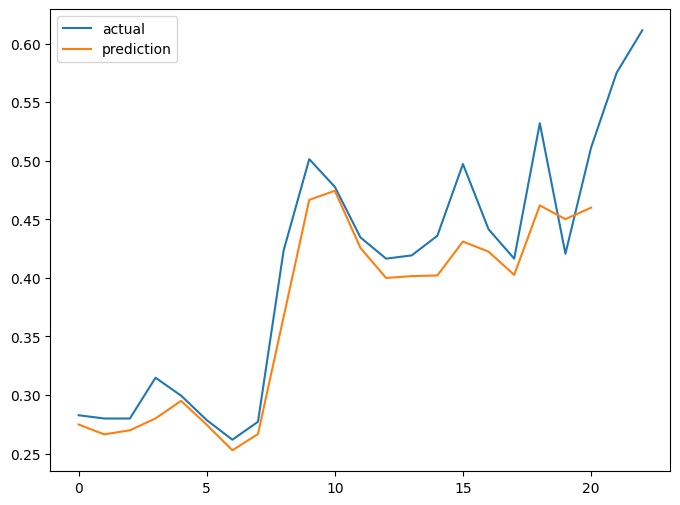

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.asarray(test['Close'])[2:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

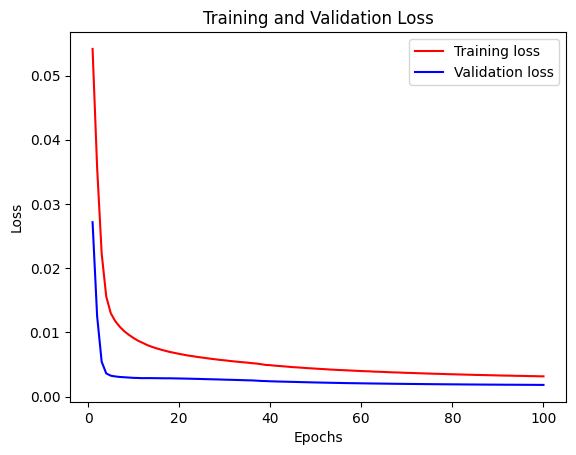

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
score = model.evaluate(test_data)
score

21/21 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 0.0045


[0.0022469786927103996, 0.004493957385420799]